# Week 5

This week, we look at some airbnb listings. We look at covariance between columns, and practice table merging.

In [1]:
library(dplyr)
library(ggplot2)
load("lab4.Rdata")


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



lab4.RData contains two data frames: listing, demo. Let's take a look.
listing basically has all the info you would find on a rental page.

In [9]:
listing %>% glimpse()

Observations: 23,624
Variables: 29
$ accommodates                <dbl> 2, 2, 6, 1, 2, 2, 2, 2, 3, 1, 2, 4, 3, ...
$ amenities                   <chr> "{}", "{\"Wireless Internet\",\"Air con...
$ availability_30             <int> 29, 18, 3, 0, 6, 22, 10, 0, 3, 20, 17, ...
$ bathrooms                   <dbl> 1.0, 1.0, 1.0, 1.0, 1.0, NA, 1.5, 1.0, ...
$ bed_type                    <chr> "Real Bed", "Real Bed", "Real Bed", "Re...
$ bedrooms                    <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ beds                        <dbl> 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, ...
$ cancellation_policy         <chr> "flexible", "flexible", "flexible", "fl...
$ city                        <chr> "palmdale", "acton", "acton", "los ange...
$ has_availability            <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,...
$ host_id                     <int> 44800067, 84615808, 71743973, 41646908,...
$ id                          <int> 8909380, 14078522, 13006928, 7898757, 1...
$ instant_bookabl

Some demographic info by zipcode are in demo

In [10]:
demo %>% head()

zipcode population median_household_income mean_household_income
1 601     17982      10816                   20349                
2 602     40260      16079                   23282                
3 603     52408      16804                   26820                
4 606      6331      12512                   15730                
5 610     28328      17475                   23360                
6 612     64816      17229                   25590

### Goal: 
Airbnb is meant for home sharing, but there are hosts with more than 20 listings. This is more like commercial hotels without regulation than home sharing. We would like to identify such users and see what their impact is on the airbnb ecosystem.

### Step 1:
host_id is a unique identifier for host. id is a unique identifier for listing. Construct a table where for each host_id, we have the number of unique ids, and the mean review_scores_value for that host_id. Call this table tb1. Name the 3 resulting columns host_id, nid, and mean_review.

In [12]:
tb1 <- listing %>% group_by(host_id) %>% summarise(nid = length(unique(id)), mean_review = mean(review_scores_value))
head(tb1)

host_id nid mean_review
1   59    1   10.0       
2  521    1    8.0       
3  767    1    8.0       
4 1158    1   10.0       
5 3041    2    8.5       
6 3144    1   10.0

### Step 2:

Look at a digital clock:
* if the minute is odd, Create a sequence of box plots, where the x axis is nid, and y axis is mean_review. Like the one in [lecture 7](https://github.com/terhorst/stats306/blob/master/lecture07/Lecture07.ipynb) right above the violin plot.
* if the minute is even, create a scatter plot of mean_review vs nid, add a smooth fitted line.
 
What do you see? If you have made both, what are the things that you can pick off from one plot but not the other?

Warning message:
“Removed 71 rows containing non-finite values (stat_boxplot).”

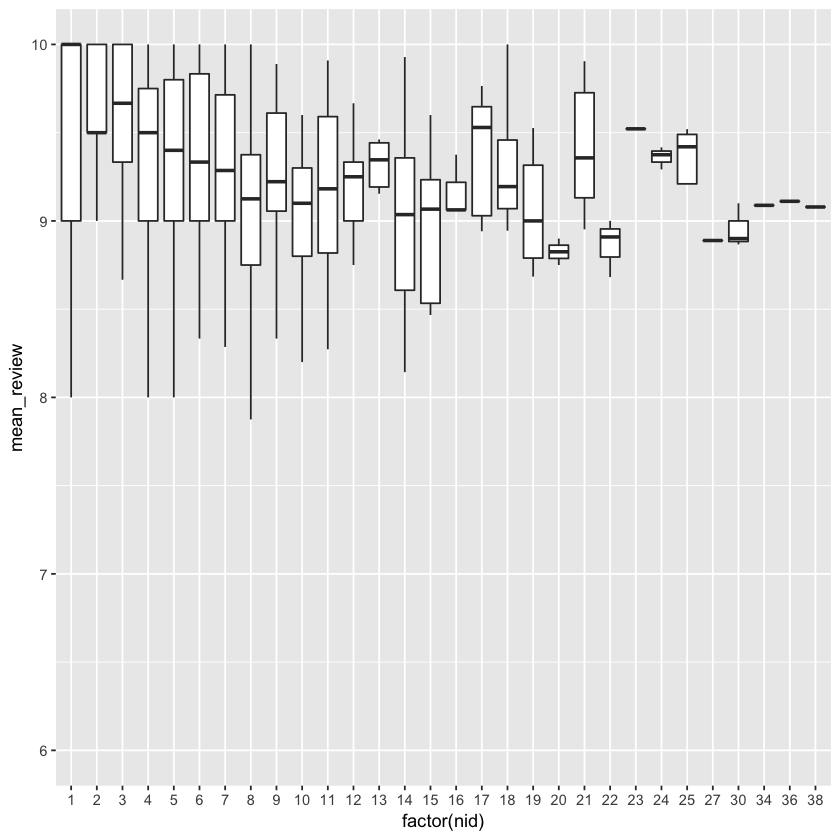

In [18]:
ggplot(data = tb1) + 
    geom_boxplot(mapping = aes(x = factor(nid), y = mean_review), outlier.shape = NA) + ylim(6,10)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


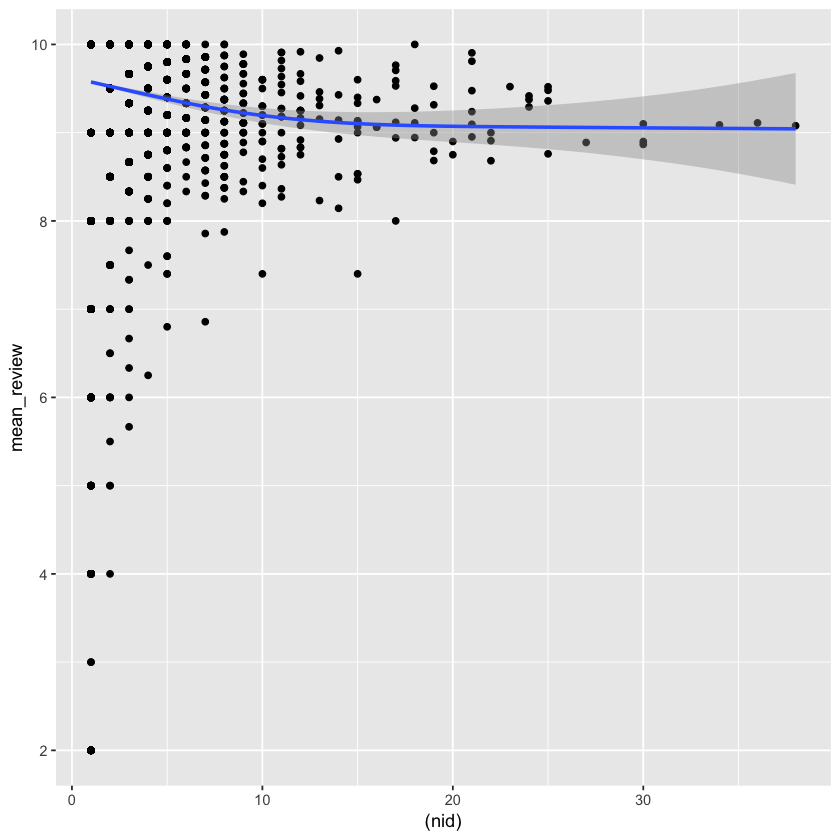

In [21]:
ggplot(data = tb1, mapping = aes(x = (nid), y = mean_review)) + 
    geom_point() + geom_smooth()

### Step 3:
Let's define commercial hosts to be hosts with >= 5 listings. Create a column in listing indicating if this row has a commercial host. (hint: you need to merge tables for this, at least I needed)

In [24]:
tb2 <- tb1 %>% mutate(if_commer = nid >= 5) %>% select(host_id, if_commer)
listing <- listing %>% left_join(tb2)

Joining, by = "host_id"


### Step 4:
In listing, find for each zipcode, the total number of listings, the number of commercial listings (any listing by a commercial host is a commercial listing), and the mean price of all listings; retain only rows with more than 25 listings. Name this table tb3, name four columns zipcode, nlist, ncomlist, and mp.

In [27]:
tb3 <- listing %>% group_by(zipcode) %>% summarise(nlist = n(), ncomlist = sum(if_commer), mp = mean(price, na.rm = T)) %>%
filter(nlist > 25)

### Step 5:
In tb3, add a column of boolean value indicating if this zipcode is "commercial heavy". We define commercial heavy as the number commercial listings exceeding 20% of the total amount of listings. Name the result tb4.

In [28]:
tb4 <- tb3 %>% mutate(com_heavy = (ncomlist/nlist) > 0.2)
tb4 %>% head

zipcode nlist ncomlist mp        com_heavy
1         249    24      134.32114 FALSE    
2 90004   290    62      115.34028  TRUE    
3 90005   195    69       90.78351  TRUE    
4 90006   279   185       60.90323  TRUE    
5 90007   113    41       59.18584  TRUE    
6 90008    46     1      111.21739 FALSE

### Step 6:
merge in demo info into tb4. Name this table tb5

In [30]:
tb5 <- tb4 %>% left_join(demo)
tb5 %>% head()

Joining, by = "zipcode"


zipcode nlist ncomlist mp        com_heavy population median_household_income
1         249    24      134.32114 FALSE        NA      NA                     
2 90004   290    62      115.34028  TRUE     64008      40612                  
3 90005   195    69       90.78351  TRUE     38979      31142                  
4 90006   279   185       60.90323  TRUE     61625      31521                  
5 90007   113    41       59.18584  TRUE     43426      22304                  
6 90008    46     1      111.21739 FALSE     31837      36564                  
  mean_household_income
1 NA                   
2 72532                
3 45224                
4 39123                
5 33382                
6 56076

### Step 7:
Create a scatter plot of mean price vs median household income with tb5. Color points by if this zipcode is commercial heavy. What do you see? What do you learn from this plot?

Warning message:
“Removed 1 rows containing missing values (geom_point).”

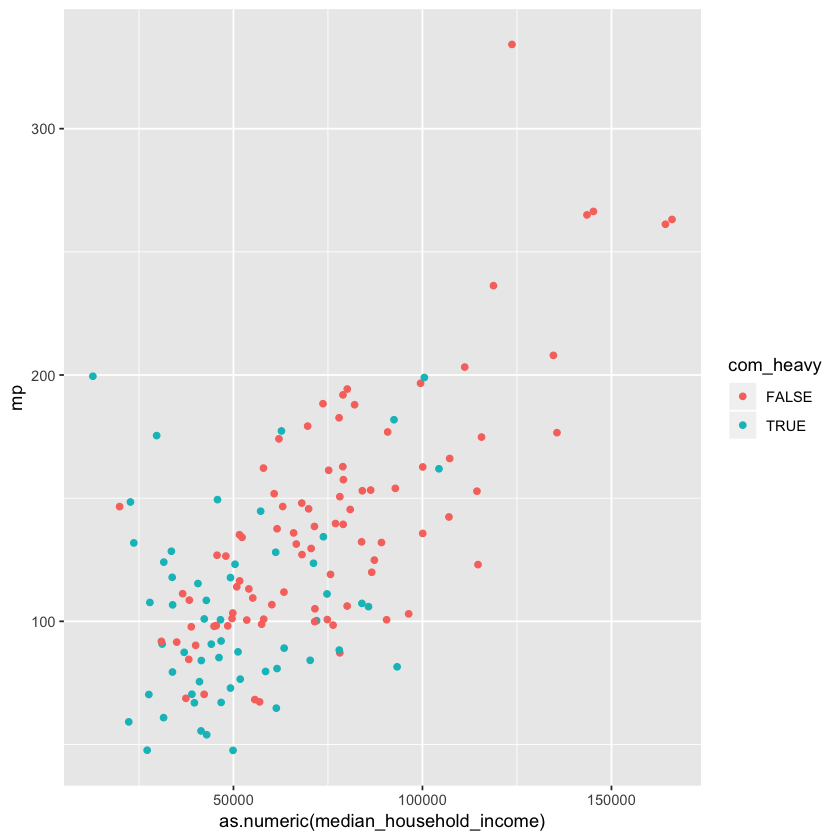

In [32]:
ggplot(data = tb5, mapping = aes(x = as.numeric(median_household_income), y = mp, color = com_heavy)) + 
    geom_point()